In [5]:
import os
import torch
import skimage
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from matplotlib import colormaps, colors
from torchvision.models import resnet101, ResNet101_Weights

from pdn import PDN
from data.cub.cub_dataset import CUBDataset, get_cub_transforms

In [6]:
train_transforms, test_transforms = get_cub_transforms(resolution=448)
dataset_val = CUBDataset(os.path.join('datasets', 'CUB'), num_attrs=312,
                         split='val', transforms=test_transforms)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=8, shuffle=True, num_workers=8)
dataloader_val_iter = iter(dataloader_val)

In [7]:
backbone = resnet101(weights=ResNet101_Weights.DEFAULT)
net = PDN(backbone, num_landmarks=4, num_classes=200)
state_dict = torch.load("pdn_CUB.pt", map_location='cpu')
net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
with open('datasets/CUB/attributes.txt', 'r') as fp:
    concepts = np.array(fp.read().splitlines())

In [31]:
device = 'cpu'
net.eval()

with torch.no_grad():
    batch = next(dataloader_val_iter)
    outputs = net(batch['pixel_values'])

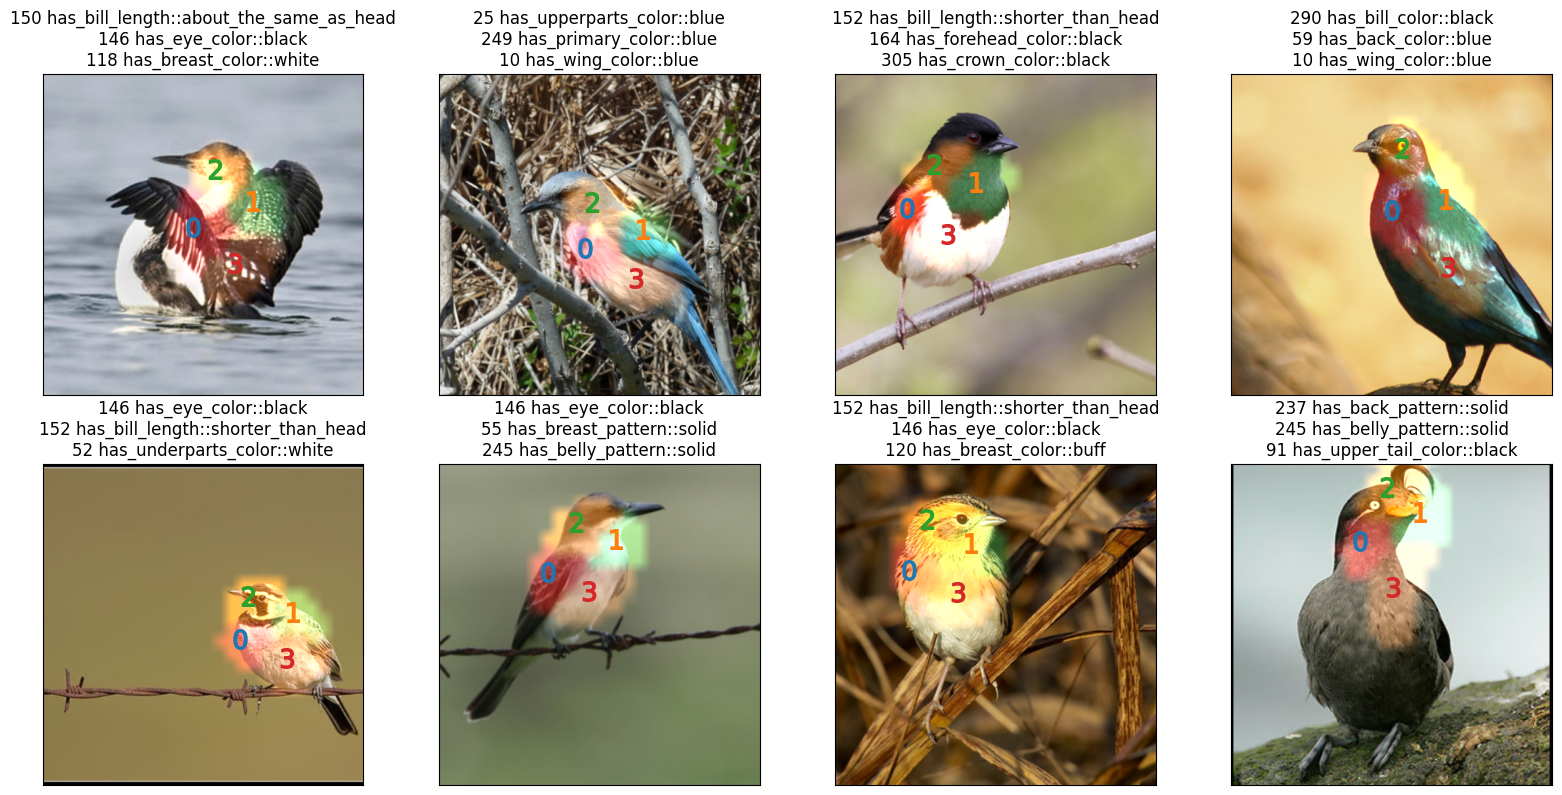

In [32]:
def get_attn_map_centroids(attn_maps: torch.Tensor):
    b, k, h, w = attn_maps.shape
    grid_x, grid_y = torch.meshgrid(torch.arange(w), torch.arange(h), indexing='xy')

    grid_x = grid_x[None, None, ...].to(attn_maps.device)
    grid_y = grid_y[None, None, ...].to(attn_maps.device)

    attn_map_sums = attn_maps.sum((-1, -2)).detach()
    cx = torch.sum(grid_x * attn_maps, dim=(-1, -2)) / attn_map_sums
    cy = torch.sum(grid_y * attn_maps, dim=(-1, -2)) / attn_map_sums
    return cx, cy, grid_x, grid_y


def attn_maps_to_rgb(attn_maps):
    h, w, k = attn_maps.shape
    color_overlay = np.zeros((h, w, 3))
    norm = colors.Normalize(vmin=0, vmax=k)
    cmap = colormaps['Set1']
    for k, map_k in enumerate(attn_maps.transpose(2, 0, 1)):
        rgb = cmap(norm(k))[:-1]
        rgb_arr = np.expand_dims(np.array(rgb), axis=(0, 1))
        color_overlay += map_k[..., np.newaxis] * rgb_arr
    return color_overlay

batch_attr_scores = outputs['attr_scores']

cx_coords, cy_coords, grid_x, grid_y = get_attn_map_centroids(outputs['attn_maps'])
batch_images = batch['pixel_values'].permute(0, 2, 3, 1).numpy().copy()
batch_attn_maps = outputs['attn_maps'].permute(0, 2, 3, 1).numpy().copy()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
b, h, w, _ = batch_images.shape
_, ah, aw, _ = batch_attn_maps.shape
bg_idx = 4
for ax, image, attn_maps, cx, cy, attr_scores in zip(axes.flatten(), batch_images, batch_attn_maps, cx_coords, cy_coords, batch_attr_scores):
    _, top_attr_idxs = torch.topk(attr_scores, k=3)
    top_concepts = concepts[top_attr_idxs.numpy()]
    attn_map = skimage.transform.resize(attn_maps, (h, w), anti_aliasing=True)
    parts, background = np.split(attn_map, [-1], axis=-1)
    color_overlay = attn_maps_to_rgb(parts)
    foreground_mask = ~(np.argmax(attn_map, axis=-1) == bg_idx)
    image_with_overlay = np.clip(image + color_overlay * 0.5, a_min=0, a_max=1)
    ax.imshow(image_with_overlay)
    x_coords = cx[:-1] * 448 / aw
    y_coords = cy[:-1] * 448 / ah
    for x, y, idx in zip(x_coords, y_coords, np.arange(bg_idx)):
        ax.scatter(x, y, marker=f'${idx}$', s=200)
    ax.set_title('\n'.join(top_concepts))
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [12]:
torch.topk(outputs['attr_scores'], k=3)

torch.return_types.topk(
values=tensor([[64.0054, 62.6255, 62.2806],
        [94.0199, 91.3247, 90.0544],
        [72.8649, 69.6674, 69.1612],
        [80.0507, 70.5814, 60.7779],
        [76.2841, 73.5936, 58.2013],
        [86.8474, 76.0809, 72.5406],
        [73.5170, 71.7417, 69.0599],
        [74.0589, 68.3283, 61.0103]]),
indices=tensor([[259, 193, 131],
        [ 24,   9,  79],
        [145, 203,  45],
        [151, 145, 244],
        [149, 220, 145],
        [145, 244,  54],
        [ 54, 244, 117],
        [145, 151, 235]]))

In [ ]:
torch.topk(outputs['attr_scores'][0], k=10)

In [ ]:
with open('datasets/CUB/attributes.txt', 'r') as fp:
    concepts = fp.read().splitlines()

In [ ]:
concepts[21]

In [ ]:
outputs['attn_maps'].shape

In [ ]:
torch.topk(outputs['attr_scores'][0], k=10)

In [ ]:
concepts = [
    'has white wing',
    'has spotted belly pattern',
    'has black throat',
    'has black eye',
    'has white throat',
    'bill length shorter than head',
    'has solid tail',
    'has black crown'
]